## Import

In [1]:
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings("ignore")
import sklearn.metrics as skm
import math
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from catboost import CatBoostClassifier
from fast_ml.feature_selection import get_constant_features
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB  
import time
import nltk
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.wordnet import WordNetLemmatizer
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

## Store the Dataset into the Dataframe

In [2]:
df = pd.read_csv('Reviews.csv')

## Information

In [3]:
df.shape

(568454, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


## Data Pre-Processing

In [6]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


### Ratings

In [7]:
initial = df.shape[0]
indexNeutral = df[ (df['Score'] == 3)].index
df.drop(indexNeutral , inplace=True)
df.reset_index(inplace = True, drop = True)
after = df.shape[0]

print("Initial Row Size",initial)
print("After Dropping",after)
print("Rows Deleted",(initial-after))

Initial Row Size 568454
After Dropping 525814
Rows Deleted 42640


Dropping neutral ratings. Let rating {1,2} denote negative review and {4,5} denote positive review and the rating {3} denotes neutral review. Thus rating {3} can be ignored.

### Target Column

In [8]:
def posneg(val):
    if val>3:
        return 'positive'
    return 'negative'

In [9]:
PosNeg = df['Score'].map(posneg)
df['Rating'] = PosNeg

### Duplicate Data

In [10]:
df = df.sort_values('ProductId')
df.reset_index(inplace = True, drop = True)
df[df[['UserId', 'ProfileName', 'Time', 'Text']].duplicated(keep=False)].head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Rating
38,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,5,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,positive
39,171160,7310172001,A74C7IARQEM1R,stucker,0,0,5,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,positive


There are duplicate data in our dataset

In [11]:
initial = df.shape[0]
df.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=True)
df.reset_index(inplace = True, drop = True)
after = df.shape[0]

print("Initial Row Size",initial)
print("After Dropping",after)
print("Rows Deleted",(initial-after))

Initial Row Size 525814
After Dropping 364173
Rows Deleted 161641


### Handling Outliers 

In [12]:
initial = df.shape[0]
df = df[df['HelpfulnessNumerator']<=df['HelpfulnessDenominator']]
after = df.shape[0]

print("Initial Row Size",initial)
print("After Dropping",after)
print("Rows Deleted",(initial-after))

Initial Row Size 364173
After Dropping 364171
Rows Deleted 2


### Null Values

In [13]:
df.isna().sum().to_frame(name='Null Values')

,Null Values
Id,0
ProductId,0
UserId,0
ProfileName,11
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,1
Text,0


Remove rows which are having null values

In [14]:
initial = df.shape[0]
df = df.dropna()
after = df.shape[0]

print("Initial Row Size",initial)
print("After Deletion",after)
print("Rows Deleted",(initial-after))

Initial Row Size 364171
After Deletion 364159
Rows Deleted 12


## Text Pre-Processing

### Stop Words

In [15]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kashi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
print(stop)

{'that', 'off', "wouldn't", 'just', "hasn't", 'my', 'doing', 'themselves', 'theirs', 'those', 're', 'are', 's', 'am', 'through', 'against', 'further', 'haven', 'all', 'it', 'she', "wasn't", 'each', "you'll", 'itself', 'he', 'you', 'both', 'aren', 'there', 'very', 't', 'an', 'they', 'o', 'while', 'should', 'at', 'the', 'was', 'y', 'about', 'have', 'had', "you'd", 'doesn', 'here', 'because', 'hadn', 'only', 'now', 'then', 'your', 'is', 'own', 'd', 'him', 'yourself', 'do', "haven't", 'on', "don't", 'where', 'above', 'for', "shan't", 'out', "you've", 'did', 'ma', 'be', 'herself', 'no', 'any', 'were', 'which', "won't", 'myself', 'hers', 'we', "weren't", "didn't", "it's", "isn't", 'ain', 'if', 'our', 'mightn', 'weren', 'more', 'their', 'won', "doesn't", 'ourselves', "you're", 've', 'couldn', 'once', 'or', 'to', 'few', 'wasn', 'same', 'shouldn', 'yours', 'most', 'hasn', 'don', 'until', 'shan', 'his', 'ours', 'can', 'than', 'does', 'its', 'll', 'this', 'up', 'some', 'has', 'not', 'why', 'betwe

Stop words like "no", "not", "don't" can change the meaning of the sentence and hence should not be dropped.

In [17]:
negative_stop = []
for i in stop:
    if "no" in i:
        negative_stop.append(str(i))
    if "n't" in i:
        negative_stop.append(str(i))
        
negative = set(negative_stop)

In [18]:
print(negative)

{"wouldn't", "didn't", "isn't", "hasn't", 'nor', "aren't", "doesn't", "couldn't", 'now', "needn't", "hadn't", "wasn't", "haven't", "don't", "mustn't", "shan't", "shouldn't", 'not', 'no', "mightn't", "won't", "weren't"}


In [19]:
stopwords = stop - negative
print(stopwords)

{'that', 'off', 'just', 'my', 'doing', 'themselves', 'theirs', 'those', 're', 'are', 's', 'am', 'through', 'against', 'further', 'haven', 'all', 'it', 'she', 'each', "you'll", 'itself', 'he', 'you', 'both', 'aren', 'there', 'very', 't', 'an', 'they', 'o', 'while', 'should', 'at', 'the', 'was', 'y', 'about', 'have', 'had', "you'd", 'doesn', 'here', 'because', 'hadn', 'only', 'then', 'your', 'is', 'own', 'd', 'him', 'yourself', 'do', 'on', 'where', 'above', 'for', 'out', "you've", 'did', 'ma', 'be', 'herself', 'any', 'were', 'which', 'myself', 'hers', 'we', "it's", 'ain', 'if', 'our', 'mightn', 'weren', 'more', 'their', 'won', 'ourselves', "you're", 've', 'couldn', 'once', 'or', 'to', 'few', 'wasn', 'same', 'shouldn', 'yours', 'most', 'hasn', 'don', 'until', 'shan', 'his', 'ours', 'can', 'than', 'does', 'its', 'll', 'this', 'up', 'some', 'has', 'why', 'between', 'below', 'what', 'i', 'me', 'by', 'again', 'her', 'after', 'these', 'down', 'into', 'isn', 'himself', 'as', 'in', 'them', 'your

These remaining stopwords are not important for our data and should be removed.

### Stemmer

In [20]:
snow = nltk.stem.SnowballStemmer('english')
print(snow.stem('tasty'))

tasti


### Text Filtering

In [21]:
def cleanhtml(rev):
    tag = re.compile('<.*?>')
    clean = re.sub(tag,'',rev) # '' is used to replace with.
    return clean

In [22]:
def cleanpunc(rev):
    tagg = re.compile('[?|!|\'|\"|#|.|,|(|)|\|\/]')
    clean = re.sub(tagg,'',rev)
    return clean

In [23]:
i=0
strl = ''
final_string = []
all_pos_words = [] # store words with positive reviews
all_neg_words = [] # store words with negative reviews
s = ''

In [24]:
for sent in df['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        cleaned_words = cleanpunc(w)
        if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
            if (cleaned_words.lower() not in stopwords):
                stemmed = (snow.stem(cleaned_words.lower())).encode('UTF-8')
                filtered_sentence.append(stemmed)
            else:
                continue
        else:
            continue
    if df['Rating'].values[i] == 'positive':
        all_pos_words.append(filtered_sentence)
    if df['Rating'].values[i] == 'negative':
        all_neg_words.append(filtered_sentence)               
    strl = b" ".join(filtered_sentence)
    final_string.append(strl)
    i+=1

In [25]:
df['Filtered_Review'] = final_string

## Data Splitting

In [26]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Rating,Filtered_Review
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,positive,b'witti littl book make son laugh loud recit c...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",positive,b'grew read sendak book watch realli rosi movi...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,positive,b'fun way children learn month year learn poem...


In [27]:
y = df.Rating
# X = df.drop('Rating', axis=1)
X = df.Filtered_Review

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [28]:
X_train.reset_index(inplace = True, drop = True)
X_test.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)
y_test.reset_index(inplace = True, drop = True)

In [29]:
X_train = X_train.to_frame()
X_test = X_test.to_frame()
y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [30]:
Train = pd.concat([X_train,y_train], axis=1)

In [31]:
print("TRAIN SIZE")
print("Train Data:",Train.shape)
print("X-Train:",X_train.shape)
print("Y-Train:",y_train.shape[0])

TRAIN SIZE
Train Data: (291327, 2)
X-Train: (291327, 1)
Y-Train: 291327


In [32]:
Test = pd.concat([X_test,y_test], axis=1)

In [33]:
print("TEST SIZE")
print("Test Data:",Test.shape)
print("X-Train:",X_test.shape)
print("Y-Train:",y_test.shape[0])

TEST SIZE
Test Data: (72832, 2)
X-Train: (72832, 1)
Y-Train: 72832


## Data Balancing 

In [34]:
Train.Rating.value_counts()

positive    245656
negative     45671
Name: Rating, dtype: int64

<AxesSubplot:xlabel='Rating', ylabel='count'>

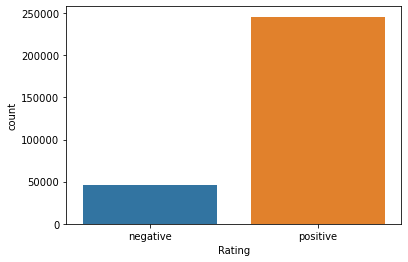

In [35]:
sns.countplot(Train['Rating'])

In [36]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [37]:
Train_resampled = X_resampled.merge(y_resampled, left_index=True, right_index=True)
Train_resampled.shape

(91342, 2)

In [38]:
Train_resampled.Rating.value_counts()

negative    45671
positive    45671
Name: Rating, dtype: int64

<AxesSubplot:xlabel='Rating', ylabel='count'>

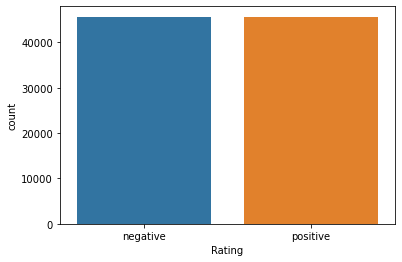

In [39]:
sns.countplot(Train_resampled['Rating'])

In [40]:
Train_resampled.head(3)

,Filtered_Review,Rating
0,b'never receiv sent wrong address correct fell...,negative
1,b'leaf bag overal packag qualiti good one fami...,negative
2,b'search grain free dri cat food pick one tri ...,negative


## Train - Cross Validation Split

In [41]:
y = Train_resampled.Rating
X = Train_resampled.Filtered_Review

X_resampled, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20)

In [42]:
X_resampled = X_resampled.to_frame()
X_cv = X_cv.to_frame()
y_train = y_train.to_frame()
y_cv = y_cv.to_frame()

In [43]:
print("TRAIN SIZE")
print("X-Train:",X_resampled.shape)
print("Y-Train:",y_train.shape[0])

TRAIN SIZE
X-Train: (73073, 1)
Y-Train: 73073


In [44]:
print("CV SIZE")
print("X-CV:",X_cv.shape)
print("Y-CV:",y_cv.shape[0])

CV SIZE
X-CV: (18269, 1)
Y-CV: 18269


## Vectorization

### Bag of Words Vectorizer

In [45]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_resampled['Filtered_Review'])

BoW_Vectorizer_X_Train = bow_vectorizer.transform(X_resampled['Filtered_Review'])
BoW_Vectorizer_X_cv = bow_vectorizer.transform(X_cv['Filtered_Review'])
BoW_Vectorizer_X_test = bow_vectorizer.transform(X_test['Filtered_Review'])

### TF-IDF Vectorizer

In [46]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_resampled['Filtered_Review'])

tfidf_X_train = tfidf_vectorizer.transform(X_resampled['Filtered_Review'])
tfidf_X_cv = tfidf_vectorizer.transform(X_cv['Filtered_Review'])
tfidf_X_test = tfidf_vectorizer.transform(X_test['Filtered_Review'])

## Label Encoding

In [47]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_cv = labelEncoder.transform(y_cv)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) 

['negative', 'positive']


In [48]:
print("TRAIN SIZE")
print("X-Train:",X_resampled.shape)
print("Y-Train:",y_train.shape[0])

TRAIN SIZE
X-Train: (73073, 1)
Y-Train: 73073


In [49]:
print("CV SIZE")
print("X-CV:",X_cv.shape)
print("Y-CV:",y_cv.shape[0])

CV SIZE
X-CV: (18269, 1)
Y-CV: 18269


## Model Training

In [50]:
Algorithm = []
R2_Score = []
R2_Score_cv = []

In [51]:
def model_training(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)
    
    Algorithm.append(name)
    R2_Score.append(accuracy_score(y_train, y_preds_train))
    R2_Score_cv.append(accuracy_score(y_test, y_preds_test))

### Logestic Regression Bag of Words

In [52]:
C = [0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['none', 'l2']

for c in C:
    for p in penalty:
        log_model = LogisticRegression(C = c, max_iter=500, random_state=1, penalty = p)
  
        model_training(model=log_model,
                       X_train = BoW_Vectorizer_X_Train,
                       y_train = y_train,
                       X_test = BoW_Vectorizer_X_cv,
                       y_test = y_cv,
                       name = 'Logestic Regression BoW '+str(c)+' '+str(p))

### Logestic Regression tf-idf


In [53]:
C = [0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['none', 'l2']

for c in C:
    for p in penalty:
        log_model = LogisticRegression(C = c, max_iter=500, random_state=1, penalty = p)
    
        model_training(model=log_model,
                       X_train = tfidf_X_train,
                       y_train = y_train,
                       X_test = tfidf_X_cv,
                       y_test = y_cv,
                       name = 'Logestic Regression tf-idf '+str(c)+' '+str(p))

#### LogesticRegression HyperParameters: 

* C = 1
* penalty = 'l2'

### Ridge Classifier Bag of Words

In [54]:
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for a in alpha:
    log_model = RidgeClassifier(alpha = a)
    
    model_training(model=log_model,
                       X_train = BoW_Vectorizer_X_Train,
                       y_train = y_train,
                       X_test = BoW_Vectorizer_X_cv,
                       y_test = y_cv,
                       name = 'Ridge Classifier BoW '+str(a))

### Ridge Classifier tf-idf

In [55]:
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for a in alpha:
    log_model = RidgeClassifier(alpha = a)
    
    model_training(model=log_model,
                       X_train = tfidf_X_train,
                       y_train = y_train,
                       X_test = tfidf_X_cv,
                       y_test = y_cv,
                       name = 'Ridge Classifier tf-idf '+str(a))

### XG-Boost Hyper Parameter Tuning

In [56]:
# random_grid = {'max_depth': [3,4,5,6,7,8,10], 'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1, 0.2, 0.4], 'subsample':[0,0.5,1], 'n_estimators':[10,20,100,120,140]}

In [57]:
# xgb_grid = RandomizedSearchCV(XGBClassifier(), random_grid, refit=True) 
# xgb_grid.fit(BoW_Vectorizer_X_Train,y_train)
# print(xgb_grid.best_score_)    
# print(xgb_grid.best_params_)

In [58]:
# xgb_grid.best_estimator_

In [59]:
# xgb_grid.best_params_

### XG-Boost Bag of Words

In [60]:
log_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=8, min_child_weight=11, 
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)
            
model_training(model=log_model,
                       X_train = BoW_Vectorizer_X_Train,
                       y_train = y_train,
                       X_test = BoW_Vectorizer_X_cv,
                       y_test = y_cv,
                       name = 'XG-Boost BoW')

[18:49:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### XG-Boost tf-idf

In [61]:
log_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=8, min_child_weight=11, 
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)
            
model_training(model=log_model,
                       X_train = tfidf_X_train,
                       y_train = y_train,
                       X_test = tfidf_X_cv,
                       y_test = y_cv,
                       name = 'XG-Boost tf-idf')

[18:50:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Bagged Decision Trees Bag of Words

In [62]:
n_estimators = [10, 100, 1000]

log_model = BaggingClassifier()
model_training(model=log_model,
                   X_train = BoW_Vectorizer_X_Train,
                   y_train = y_train,
                   X_test = BoW_Vectorizer_X_cv,
                   y_test = y_cv,
                   name = 'Bagged Decision Trees BoW')

### Bagged Decision Trees tf-idf

In [63]:
n_estimators = [10, 100, 1000]


log_model = BaggingClassifier()
model_training(model=log_model,
                   X_train = tfidf_X_train,
                   y_train = y_train,
                   X_test = tfidf_X_cv,
                   y_test = y_cv,
                   name = 'Bagged Decision Trees tf-idf')

### Random Forest Bag of Words

In [64]:
log_model = RandomForestClassifier()
model_training(model=log_model,
                   X_train = BoW_Vectorizer_X_Train,
                   y_train = y_train,
                   X_test = BoW_Vectorizer_X_cv,
                   y_test = y_cv,
                   name = 'Random Forest BoW')

### Random Forest tf-idf

In [65]:
log_model = RandomForestClassifier()
model_training(model=log_model,
                   X_train = tfidf_X_train,
                   y_train = y_train,
                   X_test = tfidf_X_cv,
                   y_test = y_cv,
                   name = 'Random Forest tf-idf')

### Naive Bayes Classifier Bag of Words

In [66]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    log_model = MultinomialNB(alpha=a)

    model_training(model=log_model,
                   X_train = BoW_Vectorizer_X_Train,
                   y_train = y_train,
                   X_test = BoW_Vectorizer_X_cv,
                   y_test = y_cv,
                   name = 'Naive Bayes Classifier BoW '+str(a))

### Naive Bayes Classifier tf-idf

In [67]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    log_model = MultinomialNB(alpha=a)

    model_training(model=log_model,
                   X_train = tfidf_X_train,
                   y_train = y_train,
                   X_test = tfidf_X_cv,
                   y_test = y_cv,
                   name = 'Naive Bayes Classifier tf-idf '+str(a))

### Cat Boost Bag of Words

In [68]:
n_estimators = [100, 200, 300]
max_depth = [3,4,5]

for n in n_estimators:
    for m in max_depth:
        log_model = CatBoostClassifier(n_estimators = n, max_depth = m )
        

        model_training(model=log_model,
               X_train = BoW_Vectorizer_X_Train,
               y_train = y_train,
               X_test = BoW_Vectorizer_X_cv,
               y_test = y_cv,
               name = 'Cat Boost BoW '+str(n)+' '+str(m))

Learning rate set to 0.5
0:	learn: 0.6359925	total: 328ms	remaining: 32.5s
1:	learn: 0.6048204	total: 438ms	remaining: 21.4s
2:	learn: 0.5832200	total: 550ms	remaining: 17.8s
3:	learn: 0.5666818	total: 670ms	remaining: 16.1s
4:	learn: 0.5546127	total: 814ms	remaining: 15.5s
5:	learn: 0.5422229	total: 933ms	remaining: 14.6s
6:	learn: 0.5302573	total: 1.05s	remaining: 14s
7:	learn: 0.5211675	total: 1.18s	remaining: 13.6s
8:	learn: 0.5126033	total: 1.31s	remaining: 13.2s
9:	learn: 0.5053130	total: 1.44s	remaining: 12.9s
10:	learn: 0.4995241	total: 1.56s	remaining: 12.6s
11:	learn: 0.4941287	total: 1.69s	remaining: 12.4s
12:	learn: 0.4877504	total: 1.82s	remaining: 12.2s
13:	learn: 0.4819214	total: 1.94s	remaining: 11.9s
14:	learn: 0.4770573	total: 2.07s	remaining: 11.8s
15:	learn: 0.4721198	total: 2.21s	remaining: 11.6s
16:	learn: 0.4682545	total: 2.33s	remaining: 11.4s
17:	learn: 0.4645068	total: 2.45s	remaining: 11.2s
18:	learn: 0.4610723	total: 2.58s	remaining: 11s
19:	learn: 0.4574447

62:	learn: 0.3544024	total: 8.58s	remaining: 5.04s
63:	learn: 0.3534658	total: 8.71s	remaining: 4.9s
64:	learn: 0.3526099	total: 8.84s	remaining: 4.76s
65:	learn: 0.3516931	total: 8.97s	remaining: 4.62s
66:	learn: 0.3508453	total: 9.11s	remaining: 4.49s
67:	learn: 0.3499735	total: 9.24s	remaining: 4.35s
68:	learn: 0.3491286	total: 9.38s	remaining: 4.21s
69:	learn: 0.3482531	total: 9.5s	remaining: 4.07s
70:	learn: 0.3474978	total: 9.63s	remaining: 3.93s
71:	learn: 0.3466333	total: 9.75s	remaining: 3.79s
72:	learn: 0.3457021	total: 9.89s	remaining: 3.66s
73:	learn: 0.3448736	total: 10s	remaining: 3.52s
74:	learn: 0.3440449	total: 10.2s	remaining: 3.38s
75:	learn: 0.3432731	total: 10.3s	remaining: 3.25s
76:	learn: 0.3425280	total: 10.4s	remaining: 3.11s
77:	learn: 0.3417474	total: 10.5s	remaining: 2.97s
78:	learn: 0.3408576	total: 10.7s	remaining: 2.85s
79:	learn: 0.3397636	total: 10.8s	remaining: 2.71s
80:	learn: 0.3389626	total: 11s	remaining: 2.58s
81:	learn: 0.3380935	total: 11.1s	rem

24:	learn: 0.4877341	total: 3.72s	remaining: 26s
25:	learn: 0.4853919	total: 3.85s	remaining: 25.8s
26:	learn: 0.4828883	total: 3.98s	remaining: 25.5s
27:	learn: 0.4800212	total: 4.13s	remaining: 25.4s
28:	learn: 0.4775865	total: 4.32s	remaining: 25.5s
29:	learn: 0.4753927	total: 4.5s	remaining: 25.5s
30:	learn: 0.4734784	total: 4.67s	remaining: 25.4s
31:	learn: 0.4712787	total: 4.82s	remaining: 25.3s
32:	learn: 0.4687049	total: 4.98s	remaining: 25.2s
33:	learn: 0.4665854	total: 5.14s	remaining: 25.1s
34:	learn: 0.4646781	total: 5.32s	remaining: 25.1s
35:	learn: 0.4628598	total: 5.49s	remaining: 25s
36:	learn: 0.4608698	total: 5.65s	remaining: 24.9s
37:	learn: 0.4587892	total: 5.81s	remaining: 24.8s
38:	learn: 0.4566038	total: 5.96s	remaining: 24.6s
39:	learn: 0.4544921	total: 6.12s	remaining: 24.5s
40:	learn: 0.4528732	total: 6.26s	remaining: 24.3s
41:	learn: 0.4510122	total: 6.38s	remaining: 24s
42:	learn: 0.4491853	total: 6.51s	remaining: 23.8s
43:	learn: 0.4473747	total: 6.63s	rema

186:	learn: 0.3479131	total: 23.6s	remaining: 1.64s
187:	learn: 0.3475834	total: 23.7s	remaining: 1.51s
188:	learn: 0.3472670	total: 23.8s	remaining: 1.39s
189:	learn: 0.3468751	total: 24s	remaining: 1.26s
190:	learn: 0.3465444	total: 24.1s	remaining: 1.13s
191:	learn: 0.3462191	total: 24.2s	remaining: 1.01s
192:	learn: 0.3458712	total: 24.4s	remaining: 883ms
193:	learn: 0.3454401	total: 24.5s	remaining: 757ms
194:	learn: 0.3451391	total: 24.6s	remaining: 631ms
195:	learn: 0.3448676	total: 24.7s	remaining: 504ms
196:	learn: 0.3445488	total: 24.8s	remaining: 378ms
197:	learn: 0.3442754	total: 25s	remaining: 252ms
198:	learn: 0.3439607	total: 25.1s	remaining: 126ms
199:	learn: 0.3436313	total: 25.2s	remaining: 0us
Learning rate set to 0.281653
0:	learn: 0.6463432	total: 171ms	remaining: 34s
1:	learn: 0.6196665	total: 314ms	remaining: 31.1s
2:	learn: 0.6009861	total: 446ms	remaining: 29.3s
3:	learn: 0.5864482	total: 587ms	remaining: 28.8s
4:	learn: 0.5741818	total: 722ms	remaining: 28.1s


148:	learn: 0.3406906	total: 20.5s	remaining: 7.03s
149:	learn: 0.3402781	total: 20.7s	remaining: 6.89s
150:	learn: 0.3398491	total: 20.8s	remaining: 6.75s
151:	learn: 0.3394091	total: 20.9s	remaining: 6.61s
152:	learn: 0.3389849	total: 21.1s	remaining: 6.47s
153:	learn: 0.3385899	total: 21.2s	remaining: 6.33s
154:	learn: 0.3382372	total: 21.3s	remaining: 6.19s
155:	learn: 0.3378467	total: 21.5s	remaining: 6.05s
156:	learn: 0.3374667	total: 21.6s	remaining: 5.91s
157:	learn: 0.3370320	total: 21.7s	remaining: 5.77s
158:	learn: 0.3366261	total: 21.8s	remaining: 5.63s
159:	learn: 0.3362197	total: 22s	remaining: 5.49s
160:	learn: 0.3358779	total: 22.1s	remaining: 5.35s
161:	learn: 0.3354520	total: 22.2s	remaining: 5.21s
162:	learn: 0.3350500	total: 22.3s	remaining: 5.07s
163:	learn: 0.3347003	total: 22.5s	remaining: 4.93s
164:	learn: 0.3343175	total: 22.6s	remaining: 4.79s
165:	learn: 0.3339708	total: 22.7s	remaining: 4.66s
166:	learn: 0.3335307	total: 22.9s	remaining: 4.52s
167:	learn: 0.

108:	learn: 0.3429957	total: 16.9s	remaining: 14.1s
109:	learn: 0.3424043	total: 17.1s	remaining: 14s
110:	learn: 0.3416605	total: 17.2s	remaining: 13.8s
111:	learn: 0.3410720	total: 17.4s	remaining: 13.6s
112:	learn: 0.3404527	total: 17.5s	remaining: 13.5s
113:	learn: 0.3398293	total: 17.7s	remaining: 13.3s
114:	learn: 0.3392450	total: 17.8s	remaining: 13.2s
115:	learn: 0.3387272	total: 18s	remaining: 13s
116:	learn: 0.3382018	total: 18.1s	remaining: 12.9s
117:	learn: 0.3376611	total: 18.3s	remaining: 12.7s
118:	learn: 0.3371018	total: 18.4s	remaining: 12.5s
119:	learn: 0.3361347	total: 18.6s	remaining: 12.4s
120:	learn: 0.3355919	total: 18.7s	remaining: 12.2s
121:	learn: 0.3350947	total: 18.9s	remaining: 12.1s
122:	learn: 0.3345069	total: 19s	remaining: 11.9s
123:	learn: 0.3339904	total: 19.2s	remaining: 11.7s
124:	learn: 0.3334597	total: 19.3s	remaining: 11.6s
125:	learn: 0.3328974	total: 19.5s	remaining: 11.4s
126:	learn: 0.3323977	total: 19.6s	remaining: 11.3s
127:	learn: 0.331930

68:	learn: 0.4441251	total: 9.08s	remaining: 30.4s
69:	learn: 0.4431178	total: 9.21s	remaining: 30.3s
70:	learn: 0.4419388	total: 9.33s	remaining: 30.1s
71:	learn: 0.4406513	total: 9.45s	remaining: 29.9s
72:	learn: 0.4396492	total: 9.59s	remaining: 29.8s
73:	learn: 0.4386431	total: 9.72s	remaining: 29.7s
74:	learn: 0.4376793	total: 9.84s	remaining: 29.5s
75:	learn: 0.4363702	total: 9.97s	remaining: 29.4s
76:	learn: 0.4351875	total: 10.1s	remaining: 29.2s
77:	learn: 0.4342757	total: 10.2s	remaining: 29.1s
78:	learn: 0.4333466	total: 10.3s	remaining: 28.9s
79:	learn: 0.4324792	total: 10.5s	remaining: 28.7s
80:	learn: 0.4316472	total: 10.6s	remaining: 28.6s
81:	learn: 0.4307595	total: 10.7s	remaining: 28.4s
82:	learn: 0.4299085	total: 10.8s	remaining: 28.3s
83:	learn: 0.4290985	total: 10.9s	remaining: 28.1s
84:	learn: 0.4282043	total: 11.1s	remaining: 28s
85:	learn: 0.4271253	total: 11.2s	remaining: 27.8s
86:	learn: 0.4263057	total: 11.3s	remaining: 27.7s
87:	learn: 0.4254729	total: 11.4s

229:	learn: 0.3590448	total: 28.2s	remaining: 8.59s
230:	learn: 0.3587651	total: 28.3s	remaining: 8.46s
231:	learn: 0.3584861	total: 28.4s	remaining: 8.34s
232:	learn: 0.3582202	total: 28.6s	remaining: 8.21s
233:	learn: 0.3579474	total: 28.7s	remaining: 8.09s
234:	learn: 0.3576798	total: 28.8s	remaining: 7.97s
235:	learn: 0.3573867	total: 28.9s	remaining: 7.84s
236:	learn: 0.3570720	total: 29s	remaining: 7.72s
237:	learn: 0.3568222	total: 29.2s	remaining: 7.59s
238:	learn: 0.3565726	total: 29.3s	remaining: 7.47s
239:	learn: 0.3562912	total: 29.4s	remaining: 7.35s
240:	learn: 0.3559826	total: 29.5s	remaining: 7.22s
241:	learn: 0.3556970	total: 29.6s	remaining: 7.1s
242:	learn: 0.3554443	total: 29.7s	remaining: 6.98s
243:	learn: 0.3551193	total: 29.9s	remaining: 6.85s
244:	learn: 0.3548358	total: 30s	remaining: 6.73s
245:	learn: 0.3545657	total: 30.1s	remaining: 6.61s
246:	learn: 0.3543047	total: 30.2s	remaining: 6.48s
247:	learn: 0.3540642	total: 30.3s	remaining: 6.36s
248:	learn: 0.353

90:	learn: 0.4000771	total: 12.9s	remaining: 29.7s
91:	learn: 0.3992678	total: 13.1s	remaining: 29.6s
92:	learn: 0.3985776	total: 13.2s	remaining: 29.4s
93:	learn: 0.3978700	total: 13.4s	remaining: 29.3s
94:	learn: 0.3971463	total: 13.5s	remaining: 29.1s
95:	learn: 0.3964506	total: 13.6s	remaining: 29s
96:	learn: 0.3957423	total: 13.8s	remaining: 28.9s
97:	learn: 0.3950280	total: 13.9s	remaining: 28.7s
98:	learn: 0.3943594	total: 14.1s	remaining: 28.5s
99:	learn: 0.3936789	total: 14.2s	remaining: 28.4s
100:	learn: 0.3929832	total: 14.4s	remaining: 28.3s
101:	learn: 0.3921902	total: 14.5s	remaining: 28.1s
102:	learn: 0.3915837	total: 14.6s	remaining: 28s
103:	learn: 0.3909735	total: 14.8s	remaining: 27.8s
104:	learn: 0.3903458	total: 14.9s	remaining: 27.7s
105:	learn: 0.3896913	total: 15s	remaining: 27.5s
106:	learn: 0.3890701	total: 15.2s	remaining: 27.4s
107:	learn: 0.3884420	total: 15.3s	remaining: 27.2s
108:	learn: 0.3878191	total: 15.5s	remaining: 27.1s
109:	learn: 0.3872269	total:

250:	learn: 0.3308559	total: 34.9s	remaining: 6.81s
251:	learn: 0.3305615	total: 35s	remaining: 6.67s
252:	learn: 0.3302851	total: 35.2s	remaining: 6.53s
253:	learn: 0.3299991	total: 35.3s	remaining: 6.39s
254:	learn: 0.3297518	total: 35.4s	remaining: 6.25s
255:	learn: 0.3295103	total: 35.5s	remaining: 6.11s
256:	learn: 0.3292679	total: 35.7s	remaining: 5.97s
257:	learn: 0.3290404	total: 35.8s	remaining: 5.83s
258:	learn: 0.3287880	total: 36s	remaining: 5.69s
259:	learn: 0.3285504	total: 36.1s	remaining: 5.55s
260:	learn: 0.3282284	total: 36.2s	remaining: 5.41s
261:	learn: 0.3279854	total: 36.4s	remaining: 5.28s
262:	learn: 0.3277550	total: 36.5s	remaining: 5.13s
263:	learn: 0.3274652	total: 36.6s	remaining: 5s
264:	learn: 0.3271941	total: 36.8s	remaining: 4.86s
265:	learn: 0.3269575	total: 36.9s	remaining: 4.72s
266:	learn: 0.3266742	total: 37s	remaining: 4.58s
267:	learn: 0.3263687	total: 37.2s	remaining: 4.44s
268:	learn: 0.3261558	total: 37.3s	remaining: 4.3s
269:	learn: 0.3258685	

111:	learn: 0.3682388	total: 18.2s	remaining: 30.6s
112:	learn: 0.3676145	total: 18.4s	remaining: 30.4s
113:	learn: 0.3670559	total: 18.5s	remaining: 30.2s
114:	learn: 0.3662997	total: 18.7s	remaining: 30.1s
115:	learn: 0.3656101	total: 18.8s	remaining: 29.9s
116:	learn: 0.3650199	total: 19s	remaining: 29.7s
117:	learn: 0.3644266	total: 19.1s	remaining: 29.5s
118:	learn: 0.3638501	total: 19.3s	remaining: 29.4s
119:	learn: 0.3632400	total: 19.4s	remaining: 29.2s
120:	learn: 0.3626259	total: 19.6s	remaining: 29s
121:	learn: 0.3620208	total: 19.7s	remaining: 28.8s
122:	learn: 0.3614272	total: 19.9s	remaining: 28.6s
123:	learn: 0.3606169	total: 20s	remaining: 28.4s
124:	learn: 0.3600543	total: 20.2s	remaining: 28.2s
125:	learn: 0.3595133	total: 20.3s	remaining: 28.1s
126:	learn: 0.3589104	total: 20.5s	remaining: 27.9s
127:	learn: 0.3583111	total: 20.6s	remaining: 27.7s
128:	learn: 0.3576361	total: 20.8s	remaining: 27.6s
129:	learn: 0.3571055	total: 21s	remaining: 27.4s
130:	learn: 0.356559

271:	learn: 0.3066007	total: 42.4s	remaining: 4.36s
272:	learn: 0.3063638	total: 42.5s	remaining: 4.2s
273:	learn: 0.3061269	total: 42.6s	remaining: 4.04s
274:	learn: 0.3058367	total: 42.8s	remaining: 3.89s
275:	learn: 0.3056204	total: 42.9s	remaining: 3.73s
276:	learn: 0.3054364	total: 43.1s	remaining: 3.57s
277:	learn: 0.3051872	total: 43.2s	remaining: 3.42s
278:	learn: 0.3050431	total: 43.3s	remaining: 3.26s
279:	learn: 0.3047578	total: 43.5s	remaining: 3.11s
280:	learn: 0.3045153	total: 43.6s	remaining: 2.95s
281:	learn: 0.3042549	total: 43.8s	remaining: 2.79s
282:	learn: 0.3040205	total: 43.9s	remaining: 2.64s
283:	learn: 0.3037455	total: 44.1s	remaining: 2.48s
284:	learn: 0.3035138	total: 44.2s	remaining: 2.33s
285:	learn: 0.3032809	total: 44.3s	remaining: 2.17s
286:	learn: 0.3030181	total: 44.5s	remaining: 2.01s
287:	learn: 0.3027455	total: 44.6s	remaining: 1.86s
288:	learn: 0.3024875	total: 44.8s	remaining: 1.7s
289:	learn: 0.3022267	total: 44.9s	remaining: 1.55s
290:	learn: 0.

### Cat Boost tf-idf

In [69]:
n_estimators = [100, 200, 300]
max_depth = [3,4,5]

for n in n_estimators:
    for m in max_depth:
        log_model = CatBoostClassifier(n_estimators = n, max_depth = m )
        

        model_training(model=log_model,
               X_train = tfidf_X_train,
               y_train = y_train,
               X_test = tfidf_X_cv,
               y_test = y_cv,
               name = 'Cat Boost tf-idf '+str(n)+' '+str(m))

Learning rate set to 0.5
0:	learn: 0.6356937	total: 244ms	remaining: 24.1s
1:	learn: 0.6035910	total: 475ms	remaining: 23.3s
2:	learn: 0.5833500	total: 707ms	remaining: 22.9s
3:	learn: 0.5669582	total: 941ms	remaining: 22.6s
4:	learn: 0.5537522	total: 1.17s	remaining: 22.2s
5:	learn: 0.5411566	total: 1.39s	remaining: 21.7s
6:	learn: 0.5286071	total: 1.62s	remaining: 21.5s
7:	learn: 0.5183919	total: 1.83s	remaining: 21.1s
8:	learn: 0.5101211	total: 2.05s	remaining: 20.7s
9:	learn: 0.5039881	total: 2.29s	remaining: 20.6s
10:	learn: 0.4974121	total: 2.5s	remaining: 20.3s
11:	learn: 0.4905985	total: 2.72s	remaining: 19.9s
12:	learn: 0.4842092	total: 2.93s	remaining: 19.6s
13:	learn: 0.4783431	total: 3.15s	remaining: 19.3s
14:	learn: 0.4726293	total: 3.36s	remaining: 19.1s
15:	learn: 0.4683257	total: 3.59s	remaining: 18.9s
16:	learn: 0.4642170	total: 3.8s	remaining: 18.6s
17:	learn: 0.4593346	total: 4.02s	remaining: 18.3s
18:	learn: 0.4558667	total: 4.23s	remaining: 18s
19:	learn: 0.4514367

62:	learn: 0.3458935	total: 17.3s	remaining: 10.2s
63:	learn: 0.3445936	total: 17.6s	remaining: 9.92s
64:	learn: 0.3435631	total: 17.9s	remaining: 9.64s
65:	learn: 0.3424260	total: 18.2s	remaining: 9.37s
66:	learn: 0.3414664	total: 18.4s	remaining: 9.08s
67:	learn: 0.3405244	total: 18.7s	remaining: 8.8s
68:	learn: 0.3394949	total: 19s	remaining: 8.52s
69:	learn: 0.3385056	total: 19.2s	remaining: 8.25s
70:	learn: 0.3375387	total: 19.5s	remaining: 7.97s
71:	learn: 0.3363176	total: 19.8s	remaining: 7.7s
72:	learn: 0.3351531	total: 20.1s	remaining: 7.43s
73:	learn: 0.3343185	total: 20.4s	remaining: 7.15s
74:	learn: 0.3334349	total: 20.6s	remaining: 6.88s
75:	learn: 0.3325425	total: 20.9s	remaining: 6.62s
76:	learn: 0.3312412	total: 21.2s	remaining: 6.34s
77:	learn: 0.3304331	total: 21.5s	remaining: 6.07s
78:	learn: 0.3293799	total: 21.8s	remaining: 5.8s
79:	learn: 0.3285160	total: 22.1s	remaining: 5.51s
80:	learn: 0.3276104	total: 22.3s	remaining: 5.23s
81:	learn: 0.3268643	total: 22.6s	re

25:	learn: 0.4807987	total: 5.41s	remaining: 36.2s
26:	learn: 0.4783407	total: 5.61s	remaining: 35.9s
27:	learn: 0.4758953	total: 5.79s	remaining: 35.6s
28:	learn: 0.4736406	total: 5.99s	remaining: 35.3s
29:	learn: 0.4710429	total: 6.18s	remaining: 35s
30:	learn: 0.4687015	total: 6.38s	remaining: 34.8s
31:	learn: 0.4667115	total: 6.58s	remaining: 34.6s
32:	learn: 0.4645192	total: 6.79s	remaining: 34.4s
33:	learn: 0.4616669	total: 7.01s	remaining: 34.2s
34:	learn: 0.4592386	total: 7.21s	remaining: 34s
35:	learn: 0.4570943	total: 7.43s	remaining: 33.9s
36:	learn: 0.4549316	total: 7.65s	remaining: 33.7s
37:	learn: 0.4531394	total: 7.86s	remaining: 33.5s
38:	learn: 0.4505459	total: 8.05s	remaining: 33.2s
39:	learn: 0.4481507	total: 8.25s	remaining: 33s
40:	learn: 0.4460112	total: 8.44s	remaining: 32.7s
41:	learn: 0.4441274	total: 8.65s	remaining: 32.5s
42:	learn: 0.4421358	total: 8.87s	remaining: 32.4s
43:	learn: 0.4402895	total: 9.07s	remaining: 32.1s
44:	learn: 0.4386729	total: 9.26s	rem

186:	learn: 0.3336737	total: 36.2s	remaining: 2.52s
187:	learn: 0.3333082	total: 36.4s	remaining: 2.32s
188:	learn: 0.3329001	total: 36.6s	remaining: 2.13s
189:	learn: 0.3325600	total: 36.7s	remaining: 1.93s
190:	learn: 0.3321401	total: 36.9s	remaining: 1.74s
191:	learn: 0.3317771	total: 37.1s	remaining: 1.55s
192:	learn: 0.3314164	total: 37.3s	remaining: 1.35s
193:	learn: 0.3310803	total: 37.5s	remaining: 1.16s
194:	learn: 0.3307416	total: 37.7s	remaining: 966ms
195:	learn: 0.3303974	total: 37.9s	remaining: 773ms
196:	learn: 0.3299717	total: 38.1s	remaining: 580ms
197:	learn: 0.3296440	total: 38.3s	remaining: 386ms
198:	learn: 0.3293141	total: 38.4s	remaining: 193ms
199:	learn: 0.3290258	total: 38.6s	remaining: 0us
Learning rate set to 0.281653
0:	learn: 0.6463862	total: 318ms	remaining: 1m 3s
1:	learn: 0.6192647	total: 615ms	remaining: 1m
2:	learn: 0.6003956	total: 886ms	remaining: 58.2s
3:	learn: 0.5857992	total: 1.16s	remaining: 57.1s
4:	learn: 0.5736585	total: 1.43s	remaining: 55.

147:	learn: 0.3276583	total: 39.9s	remaining: 14s
148:	learn: 0.3272327	total: 40.2s	remaining: 13.7s
149:	learn: 0.3267941	total: 40.4s	remaining: 13.5s
150:	learn: 0.3262467	total: 40.7s	remaining: 13.2s
151:	learn: 0.3257767	total: 41s	remaining: 13s
152:	learn: 0.3253920	total: 41.3s	remaining: 12.7s
153:	learn: 0.3249652	total: 41.6s	remaining: 12.4s
154:	learn: 0.3245285	total: 41.9s	remaining: 12.2s
155:	learn: 0.3241302	total: 42.1s	remaining: 11.9s
156:	learn: 0.3236886	total: 42.4s	remaining: 11.6s
157:	learn: 0.3232265	total: 42.7s	remaining: 11.4s
158:	learn: 0.3228306	total: 43s	remaining: 11.1s
159:	learn: 0.3224167	total: 43.3s	remaining: 10.8s
160:	learn: 0.3220227	total: 43.5s	remaining: 10.5s
161:	learn: 0.3216123	total: 43.8s	remaining: 10.3s
162:	learn: 0.3212155	total: 44.1s	remaining: 10s
163:	learn: 0.3208478	total: 44.4s	remaining: 9.74s
164:	learn: 0.3204784	total: 44.7s	remaining: 9.47s
165:	learn: 0.3200630	total: 44.9s	remaining: 9.21s
166:	learn: 0.3196531	

107:	learn: 0.3331577	total: 41s	remaining: 35s
108:	learn: 0.3325206	total: 41.4s	remaining: 34.6s
109:	learn: 0.3319023	total: 41.8s	remaining: 34.2s
110:	learn: 0.3311302	total: 42.2s	remaining: 33.8s
111:	learn: 0.3304922	total: 42.5s	remaining: 33.4s
112:	learn: 0.3297077	total: 42.9s	remaining: 33s
113:	learn: 0.3290248	total: 43.3s	remaining: 32.7s
114:	learn: 0.3284214	total: 43.7s	remaining: 32.3s
115:	learn: 0.3277339	total: 44.1s	remaining: 32s
116:	learn: 0.3271939	total: 44.6s	remaining: 31.6s
117:	learn: 0.3265600	total: 45s	remaining: 31.3s
118:	learn: 0.3259394	total: 45.4s	remaining: 30.9s
119:	learn: 0.3253005	total: 45.8s	remaining: 30.6s
120:	learn: 0.3247266	total: 46.3s	remaining: 30.2s
121:	learn: 0.3240878	total: 46.7s	remaining: 29.9s
122:	learn: 0.3235505	total: 47.2s	remaining: 29.5s
123:	learn: 0.3228712	total: 47.6s	remaining: 29.2s
124:	learn: 0.3222955	total: 47.9s	remaining: 28.8s
125:	learn: 0.3217334	total: 48.3s	remaining: 28.4s
126:	learn: 0.3211626	

67:	learn: 0.4383763	total: 13.9s	remaining: 47.3s
68:	learn: 0.4372958	total: 14.1s	remaining: 47.1s
69:	learn: 0.4360813	total: 14.3s	remaining: 46.9s
70:	learn: 0.4350440	total: 14.5s	remaining: 46.7s
71:	learn: 0.4335481	total: 14.7s	remaining: 46.4s
72:	learn: 0.4325662	total: 14.9s	remaining: 46.2s
73:	learn: 0.4315457	total: 15.1s	remaining: 46.1s
74:	learn: 0.4305792	total: 15.3s	remaining: 46s
75:	learn: 0.4296096	total: 15.5s	remaining: 45.8s
76:	learn: 0.4286310	total: 15.7s	remaining: 45.6s
77:	learn: 0.4276356	total: 15.9s	remaining: 45.4s
78:	learn: 0.4266599	total: 16.1s	remaining: 45.1s
79:	learn: 0.4256738	total: 16.3s	remaining: 44.9s
80:	learn: 0.4246671	total: 16.5s	remaining: 44.7s
81:	learn: 0.4237249	total: 16.7s	remaining: 44.5s
82:	learn: 0.4226349	total: 16.9s	remaining: 44.2s
83:	learn: 0.4217594	total: 17.1s	remaining: 44s
84:	learn: 0.4209415	total: 17.3s	remaining: 43.7s
85:	learn: 0.4200160	total: 17.5s	remaining: 43.5s
86:	learn: 0.4192317	total: 17.7s	r

227:	learn: 0.3468484	total: 45.5s	remaining: 14.4s
228:	learn: 0.3465200	total: 45.7s	remaining: 14.2s
229:	learn: 0.3462081	total: 45.9s	remaining: 14s
230:	learn: 0.3458574	total: 46.1s	remaining: 13.8s
231:	learn: 0.3455387	total: 46.3s	remaining: 13.6s
232:	learn: 0.3452671	total: 46.5s	remaining: 13.4s
233:	learn: 0.3449799	total: 46.7s	remaining: 13.2s
234:	learn: 0.3446396	total: 46.8s	remaining: 13s
235:	learn: 0.3443611	total: 47s	remaining: 12.8s
236:	learn: 0.3440759	total: 47.2s	remaining: 12.5s
237:	learn: 0.3438163	total: 47.4s	remaining: 12.3s
238:	learn: 0.3435429	total: 47.6s	remaining: 12.1s
239:	learn: 0.3432491	total: 47.8s	remaining: 12s
240:	learn: 0.3429462	total: 48s	remaining: 11.8s
241:	learn: 0.3426615	total: 48.2s	remaining: 11.5s
242:	learn: 0.3423042	total: 48.4s	remaining: 11.3s
243:	learn: 0.3420712	total: 48.6s	remaining: 11.1s
244:	learn: 0.3417631	total: 48.7s	remaining: 10.9s
245:	learn: 0.3415054	total: 48.9s	remaining: 10.7s
246:	learn: 0.3411551	

86:	learn: 0.3961226	total: 24.3s	remaining: 59.6s
87:	learn: 0.3952349	total: 24.6s	remaining: 59.4s
88:	learn: 0.3943468	total: 24.9s	remaining: 59s
89:	learn: 0.3934143	total: 25.1s	remaining: 58.7s
90:	learn: 0.3926328	total: 25.4s	remaining: 58.4s
91:	learn: 0.3918494	total: 25.7s	remaining: 58.1s
92:	learn: 0.3909584	total: 26s	remaining: 57.9s
93:	learn: 0.3900583	total: 26.3s	remaining: 57.6s
94:	learn: 0.3891630	total: 26.6s	remaining: 57.4s
95:	learn: 0.3882916	total: 26.9s	remaining: 57.2s
96:	learn: 0.3875470	total: 27.2s	remaining: 56.8s
97:	learn: 0.3867300	total: 27.4s	remaining: 56.5s
98:	learn: 0.3859415	total: 27.7s	remaining: 56.2s
99:	learn: 0.3852341	total: 28s	remaining: 55.9s
100:	learn: 0.3845627	total: 28.2s	remaining: 55.6s
101:	learn: 0.3838514	total: 28.5s	remaining: 55.3s
102:	learn: 0.3831231	total: 28.8s	remaining: 55s
103:	learn: 0.3823275	total: 29.1s	remaining: 54.8s
104:	learn: 0.3816760	total: 29.3s	remaining: 54.5s
105:	learn: 0.3810107	total: 29.6s

246:	learn: 0.3186975	total: 1m 7s	remaining: 14.4s
247:	learn: 0.3184299	total: 1m 7s	remaining: 14.2s
248:	learn: 0.3181576	total: 1m 7s	remaining: 13.9s
249:	learn: 0.3178448	total: 1m 8s	remaining: 13.6s
250:	learn: 0.3175800	total: 1m 8s	remaining: 13.3s
251:	learn: 0.3173164	total: 1m 8s	remaining: 13.1s
252:	learn: 0.3170627	total: 1m 8s	remaining: 12.8s
253:	learn: 0.3167833	total: 1m 9s	remaining: 12.5s
254:	learn: 0.3164636	total: 1m 9s	remaining: 12.2s
255:	learn: 0.3162080	total: 1m 9s	remaining: 12s
256:	learn: 0.3159470	total: 1m 9s	remaining: 11.7s
257:	learn: 0.3156688	total: 1m 10s	remaining: 11.4s
258:	learn: 0.3154274	total: 1m 10s	remaining: 11.2s
259:	learn: 0.3151711	total: 1m 10s	remaining: 10.9s
260:	learn: 0.3149196	total: 1m 11s	remaining: 10.6s
261:	learn: 0.3147103	total: 1m 11s	remaining: 10.3s
262:	learn: 0.3144678	total: 1m 11s	remaining: 10.1s
263:	learn: 0.3141483	total: 1m 11s	remaining: 9.79s
264:	learn: 0.3139244	total: 1m 12s	remaining: 9.52s
265:	l

104:	learn: 0.3650751	total: 41.1s	remaining: 1m 16s
105:	learn: 0.3643109	total: 41.5s	remaining: 1m 15s
106:	learn: 0.3635810	total: 41.9s	remaining: 1m 15s
107:	learn: 0.3629261	total: 42.3s	remaining: 1m 15s
108:	learn: 0.3622968	total: 42.6s	remaining: 1m 14s
109:	learn: 0.3615103	total: 43s	remaining: 1m 14s
110:	learn: 0.3608366	total: 43.4s	remaining: 1m 13s
111:	learn: 0.3601092	total: 43.8s	remaining: 1m 13s
112:	learn: 0.3594963	total: 44.3s	remaining: 1m 13s
113:	learn: 0.3588860	total: 44.6s	remaining: 1m 12s
114:	learn: 0.3582537	total: 45s	remaining: 1m 12s
115:	learn: 0.3576183	total: 45.4s	remaining: 1m 11s
116:	learn: 0.3569465	total: 45.7s	remaining: 1m 11s
117:	learn: 0.3562438	total: 46.1s	remaining: 1m 11s
118:	learn: 0.3556627	total: 46.5s	remaining: 1m 10s
119:	learn: 0.3548568	total: 46.9s	remaining: 1m 10s
120:	learn: 0.3541430	total: 47.3s	remaining: 1m 9s
121:	learn: 0.3534329	total: 47.7s	remaining: 1m 9s
122:	learn: 0.3528155	total: 48.1s	remaining: 1m 9s


261:	learn: 0.2967844	total: 1m 39s	remaining: 14.4s
262:	learn: 0.2965169	total: 1m 39s	remaining: 14s
263:	learn: 0.2962169	total: 1m 40s	remaining: 13.7s
264:	learn: 0.2959411	total: 1m 40s	remaining: 13.3s
265:	learn: 0.2956507	total: 1m 40s	remaining: 12.9s
266:	learn: 0.2954240	total: 1m 41s	remaining: 12.5s
267:	learn: 0.2950998	total: 1m 41s	remaining: 12.1s
268:	learn: 0.2948555	total: 1m 42s	remaining: 11.8s
269:	learn: 0.2945365	total: 1m 42s	remaining: 11.4s
270:	learn: 0.2942268	total: 1m 42s	remaining: 11s
271:	learn: 0.2939042	total: 1m 43s	remaining: 10.6s
272:	learn: 0.2936233	total: 1m 43s	remaining: 10.2s
273:	learn: 0.2933762	total: 1m 43s	remaining: 9.86s
274:	learn: 0.2931092	total: 1m 44s	remaining: 9.47s
275:	learn: 0.2928482	total: 1m 44s	remaining: 9.1s
276:	learn: 0.2924490	total: 1m 44s	remaining: 8.72s
277:	learn: 0.2921680	total: 1m 45s	remaining: 8.34s
278:	learn: 0.2918515	total: 1m 45s	remaining: 7.95s
279:	learn: 0.2915940	total: 1m 46s	remaining: 7.57

### Extra Trees Classifier Bag of Words

In [70]:
log_model = ExtraTreesClassifier()
        
model_training(model=log_model,
               X_train = BoW_Vectorizer_X_Train,
               y_train = y_train,
               X_test = BoW_Vectorizer_X_cv,
               y_test = y_cv,
               name = 'Extra Trees Classifier BoW')

### Extra Trees Classifier tf-idf

In [71]:
log_model = ExtraTreesClassifier()

model_training(model=log_model,
           X_train = tfidf_X_train,
           y_train = y_train,
           X_test = tfidf_X_cv,
           y_test = y_cv,
           name = 'Extra Trees Classifier tf-idf')

## Comparison Table

In [72]:
comp = pd.DataFrame(list(zip(Algorithm, R2_Score, R2_Score_cv)), columns =['Algorithm', 'R2_Score', 'R2_Score_cv']) 
comp.sort_values(by = 'R2_Score_cv', ascending = False, inplace = True)
comp.reset_index(inplace = True, drop = True)

In [73]:
comp.head(5)

,Algorithm,R2_Score,R2_Score_cv
0,Logestic Regression tf-idf 1 l2,0.901701,0.882752
1,Ridge Classifier tf-idf 1.0,0.912936,0.878975
2,Logestic Regression tf-idf 10 l2,0.919943,0.878811
3,Logestic Regression BoW 0.1 l2,0.903713,0.878537
4,Ridge Classifier tf-idf 0.9,0.913306,0.878100


## Test Data

In [74]:
log_model = LogisticRegression(C = 1, max_iter=500, random_state=1, penalty = 'l2')
log_model.fit(tfidf_X_train, y_train)
y_preds_test = log_model.predict(tfidf_X_test)

In [75]:
print(skm.accuracy_score(y_test, y_preds_test))
print(classification_report(y_test,y_preds_test,digits=5))

0.8821671792618629
              precision    recall  f1-score   support

           0    0.58206   0.88464   0.70214     11434
           1    0.97621   0.88171   0.92656     61398

    accuracy                        0.88217     72832
   macro avg    0.77914   0.88317   0.81435     72832
weighted avg    0.91434   0.88217   0.89132     72832



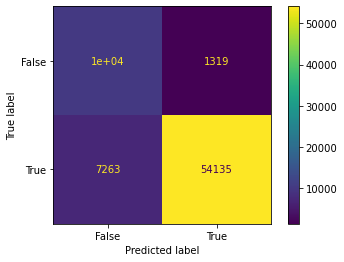

In [76]:
confusion_matrix = metrics.confusion_matrix(y_test, y_preds_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()